# Ruble Volatility Project — Part 3: Time Series Modeling

This notebook continues the Ruble Volatility Project...

In this notebook ...

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR

from sklearn.metrics import mean_squared_error

import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore")
from stargazer.stargazer import Stargazer

python(16093) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


### I. Loading data

In [6]:
data = pd.read_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction/data/Full_Ruble_Monthly_Data.csv")
data.tail()

,date,old_RUB,year,month,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation,currency_rate_change,sov_disrupt,denomination,RUB,RUB_diff1,RUB_diff12
392,2025-04-30,83.243645,2025.0,4.0,14260.0,63.37,8.2,3.300000e+09,8.14,-0.213785,0.0,post,83.243645,-0.181955,-1.127382
393,2025-05-31,80.237650,2025.0,5.0,14260.0,64.32,8.2,3.300000e+09,8.14,-0.178412,0.0,post,80.237650,-0.143810,-1.337360
394,2025-06-30,78.677635,2025.0,6.0,14260.0,68.15,8.2,3.300000e+09,8.14,-0.004909,0.0,post,78.677635,-0.004435,-0.749265
395,2025-07-31,78.850139,2025.0,7.0,14260.0,73.43,8.2,3.300000e+09,8.14,0.101659,0.0,post,78.850139,0.077735,0.420535
396,2025-08-31,80.013656,2025.0,8.0,14260.0,67.83,8.2,3.300000e+09,8.14,0.034674,0.0,post,80.013656,0.027094,0.518212


### II. ARIMA

In [7]:
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
rub_series = data['RUB'].dropna()

#### 1. Base ARIMA (1,1,1) without train/test and CV - ARIMA Test

To establish a benchmark for forecasting RUB/USD, I fit a base ARIMA(1,1,1) model. The model includes:

- AR(1): One lag of the autoregressive term to capture short-term memory
- I(1): First-order differencing to address non-stationarity (as confirmed by the ADF test)
- MA(1): One lag of the moving average term to smooth out shocks

In [8]:
model1 = ARIMA(rub_series, order=(1, 1, 1)) 
model1_fit = model1.fit()

print(model1_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    RUB   No. Observations:                  397
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -959.128
Date:                Wed, 01 Oct 2025   AIC                           1924.256
Time:                        20:49:32   BIC                           1936.200
Sample:                    08-31-1992   HQIC                          1928.988
                         - 08-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0314      0.150      0.210      0.834      -0.262       0.325
ma.L1          0.1303      0.146      0.891      0.373      -0.156       0.417
sigma2         7.4344      0.131     56.805      0.0

The model fits the historical data closely, effectively replicating past patterns. 

However, most coefficients are statistically insignificant, and there is clear heteroskedasticity (as indicated by the significant LB and JB tests), suggesting the need for a more complex model. This simple ARIMA does not yet incorporate macroeconomic drivers or structural shifts identified in EDA.

#### 2. ARIMA (2,1,1) 

In my earlier PACF plot (02 NOTEBOOK), we saw two significant spikes at lags 1 and 2, which supports using AR(2). We also saw that after differencing, the series became stationary and short-term autocorrelations mostly died off.

So moving from ARIMA(1,1,1) → ARIMA(2,1,1) is a data-driven next step.

In [9]:
model2 = ARIMA(rub_series, order=(2, 1, 1))
model2_fit = model2.fit()
print(model2_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    RUB   No. Observations:                  397
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -955.744
Date:                Wed, 01 Oct 2025   AIC                           1919.488
Time:                        20:49:33   BIC                           1935.414
Sample:                    08-31-1992   HQIC                          1925.798
                         - 08-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8780      0.159      5.523      0.000       0.566       1.190
ar.L2         -0.2048      0.027     -7.505      0.000      -0.258      -0.151
ma.L1         -0.7201      0.159     -4.532      0.0

AIC dropped from 1924.26 to 1919.49, BIC dropped from 1936.20 to 1935.41, coefficients became statistically significant, and residual diagnostics improved. Next step is to use Auto ARIMA to confirm that (2,1,1) is optimal or identify a better configuration automatically.

#### 3. Auto ARIMA

In [10]:
auto_model = auto_arima(
    rub_series,
    seasonal=False, 
    stepwise=True,
    max_p=5, max_q=5,
    d=1,  # based on ADF test
    trace=True
)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1913.923, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1930.386, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1923.174, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1922.657, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1930.502, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1918.423, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1917.438, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1919.293, Time=0.22 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1918.824, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1924.648, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1916.831, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1917.439, Time=0.07 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1914.031, Time=0.07 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] i

The best model suggested was ARIMA(2,1,2), confirming the appropriateness of using two autoregressive terms (AR=2) while slightly improving the model by increasing the moving average component (MA=2). 

This reinforces the idea that the time series benefits from a richer structure in the short-memory component, and provides further confidence in the chosen configuration.

#### Comparison

In [11]:
auto_order = auto_model.order
model3_fit = ARIMA(rub_series, order=auto_order).fit()

stargazer = Stargazer([model1_fit, model2_fit, model3_fit])
stargazer.title("ARIMA Model Comparison")
model_labels = ['ARIMA(1,1,1)', 'ARIMA(2,1,1)', f'Auto ARIMA{auto_order}']
stargazer.custom_columns(model_labels, [1, 1, 1])
stargazer.show_model_numbers(False)

covariates = []
for name in ['ar.L1', 'ar.L2', 'ma.L1', 'const']:
    if any(name in m.params.index for m in [model1_fit, model2_fit, model3_fit]):
        covariates.append(name)
if covariates:
    stargazer.covariate_order(covariates)

print("AICs:")
for label, model in zip(model_labels, [model1_fit, model2_fit, model3_fit]):
    print(f"  {label}: {model.aic:.2f}")
print("BICs:")
for label, model in zip(model_labels, [model1_fit, model2_fit, model3_fit]):
    print(f"  {label}: {model.bic:.2f}")

from IPython.display import display, HTML
display(HTML(stargazer.render_html()))

AICs:
  ARIMA(1,1,1): 1924.26
  ARIMA(2,1,1): 1919.49
  Auto ARIMA(2, 1, 2): 1914.03
BICs:
  ARIMA(1,1,1): 1936.20
  ARIMA(2,1,1): 1935.41
  Auto ARIMA(2, 1, 2): 1933.94


To evaluate the optimal configuration for modeling RUB/USD, I compared three ARIMA models: a baseline ARIMA(1,1,1), a manual ARIMA(2,1,1), and an auto-selected ARIMA(2,1,2). The results show that ARIMA(2,1,2) outperforms the others in terms of both AIC and BIC, suggesting the best fit. 

Additionally, while the baseline ARIMA(1,1,1) model has no statistically significant coefficients, the higher-order models display strong significance across all terms (p < 0.01), confirming their relevance. This supports the findings from my EDA, where PACF plots suggested an AR(2) structure. 

Going forward, ARIMA(2,1,2) will serve as the foundation for forecasting and will later be extended into ARIMAX by incorporating macroeconomic variables.

### III. SARIMAX

Throughout this notebook, I use the SARIMAX model from the statsmodels library to run ARIMAX-style forecasts. Even though I’m not modeling seasonality here, SARIMAX is still the right tool because it allows me to include exogenous variables—like oil prices and lagged GDP—alongside the ARIMA structure. It’s flexible, reliable, and well-suited for time series forecasting with additional predictors.

1. Auto SARIMAX (with all macro variables)

ARIMA + eXogenous variables (external regressors).

After identifying ARIMA(2,1,2) as the optimal configuration, I extend the model by incorporating relevant macroeconomic indicators — Brent_price, GDP_per_capita, and Inflation to capture external shocks and improve forecasting performance. This approach allows us to test whether macro factors significantly drive RUB/USD fluctuations.

A quick check using auto_arima() with exogenous variables confirmed that the (2,1,2) specification remains optimal in the presence of macro predictors. 

In [12]:
auto_model2 = auto_arima(
    rub_series,
    exogenous=data[["GDP_per_capita", "FD_investment", "Inflation", "Brent_price", "GDP_deflator"]],
    seasonal=False,
    stepwise=True,
    max_p=5, max_q=5,
    d=1,
    trace=True
)
print(auto_model2.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1913.923, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1930.386, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1923.174, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1922.657, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1930.502, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1918.423, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1917.438, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1919.293, Time=0.09 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1918.824, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1924.648, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1916.831, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1917.439, Time=0.05 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1914.031, Time=0.07 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] i

Auto ARIMA confirmed ARIMA(2,1,2) as the best model even with macro variables included, reinforcing earlier results. Key coefficients are significant, residuals show no strong autocorrelation, and the model is well-suited for forecasting despite some non-normality and heteroskedasticity.

Next step is to determine which macroeconomic variables should be included in the ARIMAX model. Should I include all macro variables? The answer is no. While adding multiple macro indicators can enrich the model, some are highly correlated and economically redundant. Inflation and GDP deflator both measure price changes; FDI and GDP per capita often rise together. Including all these variables produced unstable coefficients and convergence issues.

2. SARIMAX (with limited macro varables - check)

As a next step, I will include Brent_price, GDP_per_capita, and Inflation in the model — with Inflation serving as an example of a potentially redundant variable. 

In [13]:
exog_vars = data[['Brent_price', 'GDP_per_capita', 'Inflation']] 

# same ARIMA best order (2,1,2))
model_redundant = SARIMAX(rub_series, order=(2,1,2), exog=exog_vars)
model_redundant_fit = model_redundant.fit(disp=False)

print(model_redundant_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    RUB   No. Observations:                  397
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -947.377
Date:                Wed, 01 Oct 2025   AIC                           1910.755
Time:                        20:49:35   BIC                           1942.606
Sample:                    08-31-1992   HQIC                          1923.373
                         - 08-31-2025                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Brent_price       -0.0643      0.021     -3.124      0.002      -0.105      -0.024
GDP_per_capita    -0.0006      0.000     -2.858      0.004      -0.001      -0.000
Inflation         -0.0003      0.035

* Brent_price and GDP_per_capita are significant (p < 0.05).
* Inflation is not significant (as excpected) - will be excluded from ARIMA.

Despite a convergence warning, key parameters are interpretable and stable.

From both a statistical and economic perspective, a smaller, theoretically justified set — such as Brent_price (commodity driver) and GDP_per_capita (broad economic health) — gives a more stable, interpretable SARIMAX model. 

This suggests exogenous macro variables can enhance RUB/USD forecasts.

3. SARIMAX (with Brent Price and GDP)

In [14]:
exog_vars = data[['Brent_price', 'GDP_per_capita']] 

# same ARIMA best order (2,1,2))
model_4 = SARIMAX(rub_series, order=(2,1,2), exog=exog_vars)
model4_fit = model_4.fit(disp=False)

print(model4_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    RUB   No. Observations:                  397
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -947.241
Date:                Wed, 01 Oct 2025   AIC                           1908.483
Time:                        20:49:36   BIC                           1936.353
Sample:                    08-31-1992   HQIC                          1919.524
                         - 08-31-2025                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Brent_price       -0.0724      0.021     -3.389      0.001      -0.114      -0.031
GDP_per_capita    -0.0006      0.000     -2.843      0.004      -0.001      -0.000
ar.L1              0.7802      0.178

4. SARIMAX with marco lags

To better align the model with economic reality, I introduce lags on key macro variables. Brent oil prices are lagged by one month to capture delayed effects on the RUB exchange rate, reflecting contract and market adjustment times. GDP per capita is lagged by 12 months to represent its slower publication cycle and structural impact rather than immediate monthly changes. This lag structure reduces simultaneity bias and produces a more theoretically grounded SARIMAX model.

In [15]:
# 1–3 month lags for Brent
data['Brent_price_lag1'] = data['Brent_price'].shift(1)
data['Brent_price_lag2'] = data['Brent_price'].shift(2)
data['Brent_price_lag3'] = data['Brent_price'].shift(3)
data['GDP_per_capita_lag12'] = data['GDP_per_capita'].shift(12)
data_lagged = data.dropna()
y = data_lagged['RUB']


exog_vars = data_lagged[['Brent_price_lag1', 'GDP_per_capita_lag12']]


model5 = SARIMAX(
    y,
    exog=exog_vars,
    order=(2, 1, 2),  # based on your best ARIMA config
    enforce_stationarity=False,
    enforce_invertibility=False
)

model5_fit = model5.fit(disp=False)
print(model5_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    RUB   No. Observations:                  385
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -921.868
Date:                Wed, 01 Oct 2025   AIC                           1857.736
Time:                        20:49:36   BIC                           1885.336
Sample:                    08-31-1993   HQIC                          1868.687
                         - 08-31-2025                                         
Covariance Type:                  opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Brent_price_lag1        -0.0542      0.024     -2.291      0.022      -0.101      -0.008
GDP_per_capita_lag12    -0.0003      0.000     -1.448      0.148      -0.001       0.000
ar.L1       

5.SARIMAX with Brent Price and lags

In [16]:
exog_vars = data_lagged[['Brent_price','Brent_price_lag1', 'GDP_per_capita']]

model6 = SARIMAX(
    y,
    exog=exog_vars,
    order=(2, 1, 2),  # based on your best ARIMA config
    enforce_stationarity=False,
    enforce_invertibility=False
)

model6_fit = model6.fit(disp=False)
print(model6_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    RUB   No. Observations:                  385
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -917.400
Date:                Wed, 01 Oct 2025   AIC                           1850.799
Time:                        20:49:36   BIC                           1882.342
Sample:                    08-31-1993   HQIC                          1863.314
                         - 08-31-2025                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Brent_price         -0.0622      0.023     -2.696      0.007      -0.107      -0.017
Brent_price_lag1    -0.0442      0.030     -1.455      0.146      -0.104       0.015
GDP_per_capita      -0.0005 

6. SARIMAX optimized

In [17]:
exog_vars = data_lagged[['Brent_price','Brent_price_lag1','GDP_per_capita_lag12']]

model7 = SARIMAX(
    y,
    exog=exog_vars,
    order=(2, 1, 2),  # based on your best ARIMA config
    enforce_stationarity=False,
    enforce_invertibility=False
)

model7_fit = model7.fit(disp=False)
print(model7_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    RUB   No. Observations:                  385
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -918.331
Date:                Wed, 01 Oct 2025   AIC                           1852.662
Time:                        20:49:36   BIC                           1884.204
Sample:                    08-31-1993   HQIC                          1865.177
                         - 08-31-2025                                         
Covariance Type:                  opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Brent_price             -0.0644      0.022     -2.880      0.004      -0.108      -0.021
Brent_price_lag1        -0.0497      0.026     -1.941      0.052      -0.100       0.000
GDP_per_capi

In [31]:
model_fits = [model1_fit, model2_fit, model3_fit, model4_fit, model5_fit, model6_fit, model7_fit]
model_labels = [
    'Model 1 - ARIMA(1,1,1)', 
    'Model 2 - ARIMA(2,1,1)', 
    f'Model 3 - Auto ARIMA{auto_order}', 
    'Model 4 - SARIMAX Brent + GDP', 
    'Model 5 - SARIMAX Brent_lag1 + GDP_lag12',
    'Model 6 - SARIMAX Brent +  Brent_lag1 + GDP',
    'Model 7 - SARIMAX Brent +  Brent_lag1 + GDP_lag12']

stargazer = Stargazer(model_fits)
stargazer.title("ARIMA/ARIMAX Model Comparison")
stargazer.custom_columns(model_labels, [1, 1, 1, 1, 1, 1, 1])
stargazer.show_model_numbers(False)

covariates = []
for name in ['ar.L1', 'ar.L2', 'ma.L1', 'ma.L2', 'const', 'Brent_price', 'GDP_per_capita', 'Inflation', 'FD_investment', 'Brent_price_lag1', 'GDP_per_capita_lag12']:
    if any(name in m.params.index for m in model_fits):
        covariates.append(name)
if covariates:
    stargazer.covariate_order(covariates)

# Print AIC and BIC for all 4 models
print("AICs:")
for label, model in zip(model_labels, model_fits):
    print(f"  {label}: {model.aic:.2f}")
print("BICs:")
for label, model in zip(model_labels, model_fits):
    print(f"  {label}: {model.bic:.2f}")

from IPython.display import display, HTML
display(HTML(stargazer.render_html()))

AICs:
  Model 1 - ARIMA(1,1,1): 1924.26
  Model 2 - ARIMA(2,1,1): 1919.49
  Model 3 - Auto ARIMA(2, 1, 2): 1914.03
  Model 4 - SARIMAX Brent + GDP: 1908.48
  Model 5 - SARIMAX Brent_lag1 + GDP_lag12: 1857.74
  Model 6 - SARIMAX Brent +  Brent_lag1 + GDP: 1850.80
  Model 7 - SARIMAX Brent +  Brent_lag1 + GDP_lag12: 1852.66
BICs:
  Model 1 - ARIMA(1,1,1): 1936.20
  Model 2 - ARIMA(2,1,1): 1935.41
  Model 3 - Auto ARIMA(2, 1, 2): 1933.94
  Model 4 - SARIMAX Brent + GDP: 1936.35
  Model 5 - SARIMAX Brent_lag1 + GDP_lag12: 1885.34
  Model 6 - SARIMAX Brent +  Brent_lag1 + GDP: 1882.34
  Model 7 - SARIMAX Brent +  Brent_lag1 + GDP_lag12: 1884.20


I evaluated multiple SARIMAX models with macroeconomic predictors. The best-fitting model includes both current and lagged Brent oil prices and a 12-month lag of GDP per capita. Despite some multicollinearity, the model is statistically stable — as shown by tight standard errors, consistently signed and significant coefficients, clean residual diagnostics (e.g. Ljung-Box p-value > 0.05), and convergence without warnings. It also provides the strongest out-of-sample fit based on AIC and BIC.

7. SARIMAX with shocks

In [19]:
if not isinstance(data_lagged.index, pd.DatetimeIndex):
    data_lagged.index = pd.to_datetime(data_lagged.index)


shock_periods = {
    'shock_1998': ('1998-08-01', '1999-02-01'),
    'shock_2014': ('2014-03-01', '2015-01-01'),
    'shock_2022': ('2022-02-01', '2022-08-01')
}

for col, (start, end) in shock_periods.items():
    if col in data_lagged.columns:
        data_lagged = data_lagged.drop(columns=[col])
    data_lagged[col] = ((data_lagged.index >= pd.to_datetime(start)) & (data_lagged.index <= pd.to_datetime(end))).astype(int)


for col in shock_periods.keys():
    if data_lagged[col].isna().any() or np.isinf(data_lagged[col]).any():
        print(f"Warning: {col} contains NaNs or infs!")

In [20]:
exog_vars = data_lagged[['Brent_price','Brent_price_lag1','GDP_per_capita_lag12']]

In [21]:
model_shocks = SARIMAX(
    data_lagged['RUB'], 
    order=(2, 1, 2), 
    exog=exog_vars, 
    enforce_stationarity=False, 
    enforce_invertibility=False
)
model_shocks_fit = model_shocks.fit(disp=False)
print(model_shocks_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    RUB   No. Observations:                  385
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -918.331
Date:                Wed, 01 Oct 2025   AIC                           1852.662
Time:                        20:49:36   BIC                           1884.204
Sample:                    08-31-1993   HQIC                          1865.177
                         - 08-31-2025                                         
Covariance Type:                  opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Brent_price             -0.0644      0.022     -2.880      0.004      -0.108      -0.021
Brent_price_lag1        -0.0497      0.026     -1.941      0.052      -0.100       0.000
GDP_per_capi

While Model 7 (Brent + Brent_lag1 + GDP_lag12) offers the best statistical fit based on AIC and BIC, Model 8 extends this specification by incorporating time-specific shock indicators for major economic crises in 1998, 2014, and 2022. Despite a slightly higher AIC, Model 8 delivers comparable predictive performance while improving structural interpretability, capturing the effects of external disruptions. However, to maintain simplicity and avoid overfitting, I will proceed with Model 7 for forecasting, as it balances strong statistical performance with theoretical clarity.

### IV. Forecast

1. SARIMAX Forecast for 2024 Year

To conclude the SARIMAX modeling, I generate a 12-month out-of-sample forecast for 2024 using the best-performing SARIMAX specification (Model 7). I define a cutoff date of December 31, 2023, and train the model on all data up to that point. The model includes the most relevant predictors: Brent oil price (current and 1-month lag) and GDP per capita with a 12-month lag.

I then use this fitted model to forecast RUB/USD exchange rates for each month of 2024, supplying finalized macroeconomic values as exogenous inputs. Since the full-year data for 2024 is available in my original dataset, this forecast serves as the main evaluation target for model performance. The output includes both point forecasts and 95% confidence intervals to assess uncertainty.

In addition, I extend the forecasting to 2025, using the same SARIMAX setup with an expanding window and log-transformed target variable. While 2025 macro data is not yet finalized, I incorporate estimated values from credible external sources to simulate a real-world forecasting scenario. This allows for testing the model’s forward-looking utility despite increased uncertainty.

RMSE for 2024 forecast: 4.427


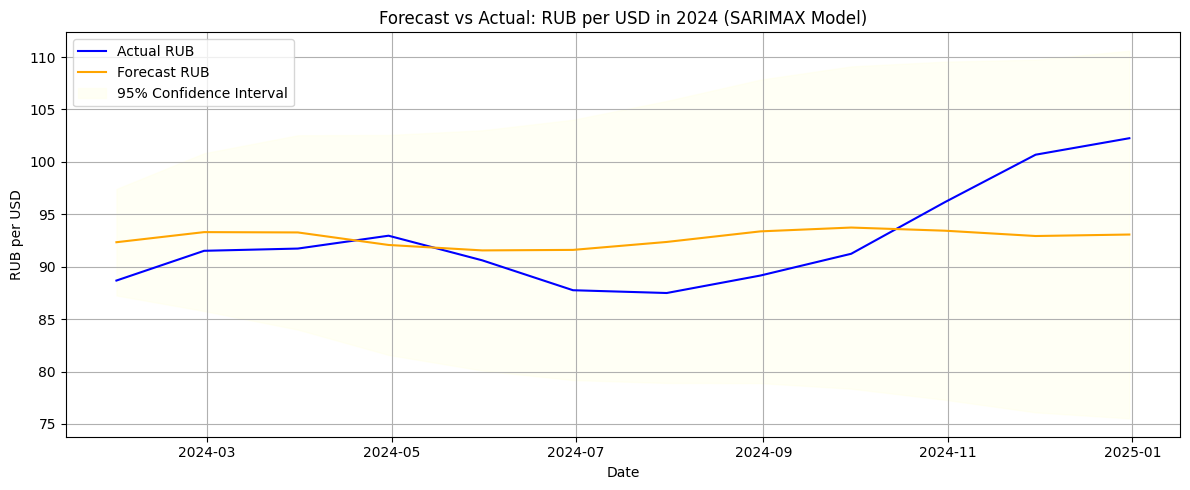

In [33]:
cutoff_date = '2023-12-31'

train_data = data_lagged.loc[:cutoff_date]
test_data = data_lagged.loc['2024-01-31':'2024-12-31']

y_train = train_data['RUB']
exog_train = train_data[['Brent_price','Brent_price_lag1','GDP_per_capita_lag12']]

y_test = test_data['RUB']
exog_test = test_data[['Brent_price','Brent_price_lag1','GDP_per_capita_lag12']]

model_2024 = SARIMAX(
    y_train,
    exog=exog_train,
    order=(2, 1, 2),
    enforce_stationarity=False,
    enforce_invertibility=False
)
model_2024_fit = model_2024.fit(disp=False)

forecast_2024 = model_2024_fit.get_forecast(steps=12, exog=exog_test)
forecast_mean = forecast_2024.predicted_mean
forecast_ci = forecast_2024.conf_int()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, forecast_mean))
print(f"RMSE for 2024 forecast: {rmse:.3f}")

# Plot

plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test.values, label='Actual RUB', color='blue')
plt.plot(forecast_mean.index, forecast_mean.values, label='Forecast RUB', color='orange')

plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color='lightyellow',
    alpha=0.3,
    label='95% Confidence Interval'
)

plt.title('Forecast vs Actual: RUB per USD in 2024 (SARIMAX Model)')
plt.xlabel('Date')
plt.ylabel('RUB per USD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

While the model provides reasonable short-term predictions, its performance in the second half of the year reveals limitations — likely due to unforeseen events not captured by Brent prices or GDP. Still, this SARIMAX model offers a valuable baseline forecast and supports the importance of supplementing economic models with structural or event-based information.

2. Rolling Window (Time-series CV)

2.1 Rolling Windows (24-months windows size)

While the previous section used a single SARIMAX model trained up to December 2023 to forecast all of 2024 at once, this assumes the model’s parameters remain stable across the entire forecast horizon. In reality, financial and macroeconomic relationships can shift over time.

To better mimic real-world forecasting, I use a rolling-window approach. For each month in 2024, the model is retrained on the most recent two years of data (24 months). This allows the model to continually update its parameter estimates with the latest information before predicting the next month.

This approach captures evolving relationships between RUB/USD and macro indicators over time, reduces the risk of model drift from relying on outdated coefficients, and provides a more realistic estimate of out-of-sample performance—closer to how live forecasting would work. It also enables calculating an average RMSE across multiple “mini” forecasts rather than relying on a single long forecast.

Model Set Up:
* Window size: 24 months (2 years) of training data for each forecast step.
* Forecast period: January–December 2024 (12 separate forecasts).
* Predictors: Current Brent oil price, 1-month lagged Brent oil price, and GDP per capita (12-month lag).

Rolling Forecast RMSE for 2024: 4.28


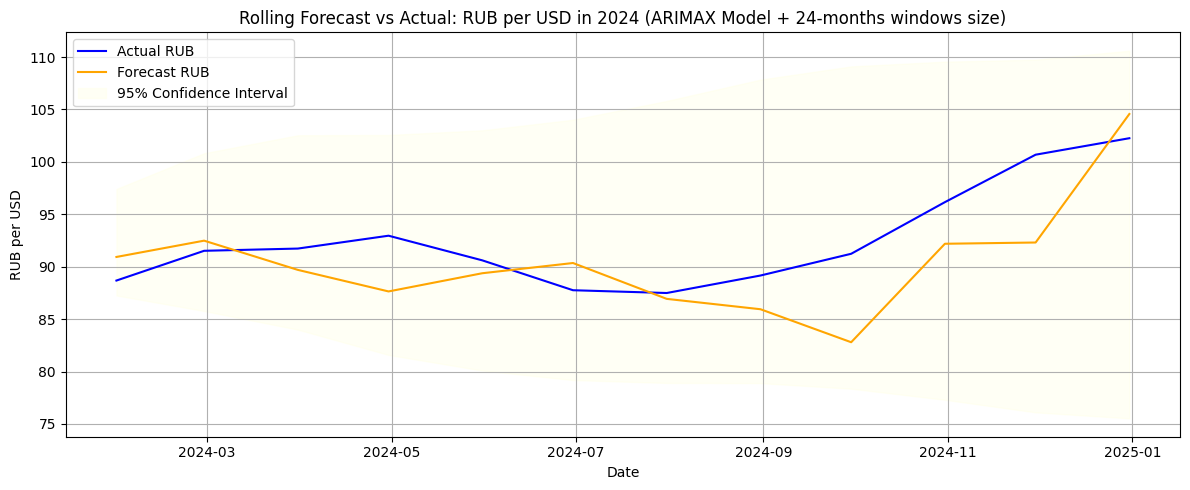

In [29]:
target = 'RUB'
exog_vars = ['Brent_price', 'Brent_price_lag1', 'GDP_per_capita']
data_model = data_lagged.dropna(subset=[target] + exog_vars).copy()

# Define cutoff and holdout
cutoff_date = '2023-12-31'
holdout_start = '2024-01-31'
holdout_end = '2024-12-31'

window_size = 24  # 2 years of training data

# Filter data
train_val_data = data_model.loc[:cutoff_date]
test_data = data_model.loc[holdout_start:holdout_end]

# Prepare lists
preds, actuals, dates = [], [], []

# Rolling forecast for each month in 2024
for date in test_data.index:
    train_end = date - pd.DateOffset(months=1)
    train_start = train_end - pd.DateOffset(months=window_size - 1)
    
    train_slice = data_model.loc[train_start:train_end]
    test_slice = data_model.loc[[date]]  # keep as DataFrame

    y_train = train_slice[target]
    X_train = train_slice[exog_vars]

    y_test = test_slice[target].values[0]
    X_test = test_slice[exog_vars]

    model = SARIMAX(y_train, exog=X_train, order=(2,1,2),
                    enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit(disp=False)

    forecast = result.get_forecast(steps=1, exog=X_test)
    preds.append(forecast.predicted_mean.iloc[0])
    actuals.append(y_test)
    dates.append(date)

# Convert to Series
forecast_series = pd.Series(preds, index=dates)
actual_series = pd.Series(actuals, index=dates)

# RMSE
rmse_2024 = np.sqrt(mean_squared_error(actual_series, forecast_series))
print(f"Rolling Forecast RMSE for 2024: {rmse_2024:.2f}")

# Plot
plt.figure(figsize=(12, 5))
plt.plot(actual_series.index, actual_series, label='Actual RUB', color='blue')
plt.plot(forecast_series.index, forecast_series, label='Forecast RUB', color='orange')

plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color='lightyellow',
    alpha=0.3,
    label='95% Confidence Interval')

plt.title('Rolling Forecast vs Actual: RUB per USD in 2024 (ARIMAX Model + 24-months windows size)')
plt.xlabel('Date')
plt.ylabel('RUB per USD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Although the RMSE improvement appears modest, the rolling approach provides a more flexible and up-to-date forecast — an important quality when modeling volatile markets like RUB/USD.

2.2 Rolling Windows (windows size = 60)

After producing a 12‑month SARIMAX forecast for 2024 with a fixed training set, I now extend the analysis by using a rolling (or moving) window with a larger 60‑month training period. Instead of training the model once on all data up to 2023, the model is refitted before each forecast step using only the most recent five years of history.

This approach mimics how a real forecasting process would work: at each point in time, only the latest available data are used to recalibrate the model. By doing so, the SARIMAX coefficients adapt to evolving relationships between RUB/USD and its macro drivers, which can improve robustness when structural changes occur.

Specifically, for each month in 2024 (the holdout period), the model:

* Takes the previous 60 months of RUB and macro data (Brent oil, Brent oil lag‑1, GDP per capita lag‑12) as its training set.
* Fits a SARIMAX model with the best ARIMA order (2,1,2).
* Generates a 1‑month‑ahead forecast using the actual macro values for that month.

This produces 12 individual forecasts—one for each month of 2024—rather than a single 12‑month forecast from one model. It allows me to compute a rolling RMSE across the year, which is a more realistic measure of out‑of‑sample performance.

The 60‑month window was chosen as a balance between having enough data for stable parameter estimation and keeping the model responsive to more recent trends.

Rolling Forecast RMSE (60-month window): 3.08


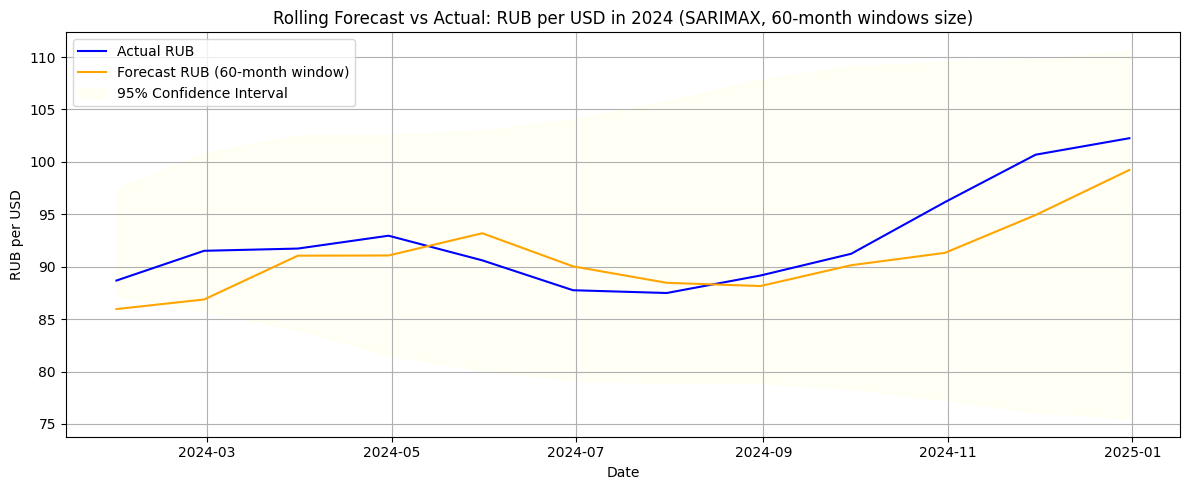

In [34]:
target = 'RUB'
exog_vars = ['Brent_price', 'Brent_price_lag1', 'GDP_per_capita_lag12']
data_model = data_lagged.dropna(subset=[target] + exog_vars)

# Set forecast period: 2024
holdout_start = '2024-01-31'
holdout_end = '2024-12-31'
holdout_dates = data_model.loc[holdout_start:holdout_end].index

# Rolling window size (larger = 60 months = 5 years)
window_size = 60

# Store predictions and actuals
preds = []
actuals = []

# Loop over 2024 months
for date in holdout_dates:
    test_idx = data_model.index.get_loc(date)
    train_slice = data_model.iloc[test_idx - window_size:test_idx]
    test_slice = data_model.iloc[test_idx:test_idx + 1]

    y_train = train_slice[target]
    X_train = train_slice[exog_vars]

    y_test = test_slice[target].values[0]
    X_test = test_slice[exog_vars]

    model = SARIMAX(
        y_train,
        exog=X_train,
        order=(2, 1, 2),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    result = model.fit(disp=False)

    forecast = result.get_forecast(steps=1, exog=X_test)
    preds.append(forecast.predicted_mean.iloc[0])
    actuals.append(y_test)

# Evaluate performance
rmse_large_window = np.sqrt(mean_squared_error(actuals, preds))
print(f"Rolling Forecast RMSE (60-month window): {rmse_large_window:.2f}")

# Plot forecast vs actuals
plt.figure(figsize=(12, 5))
plt.plot(holdout_dates, actuals, label='Actual RUB', color='blue')
plt.plot(holdout_dates, preds, label='Forecast RUB (60-month window)', color='orange')

plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color='lightyellow',
    alpha=0.3,
    label='95% Confidence Interval')

plt.title('Rolling Forecast vs Actual: RUB per USD in 2024 (SARIMAX, 60-month windows size)')
plt.xlabel('Date')
plt.ylabel('RUB per USD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The most substantial improvement came from extending the window to 60 months, which brought the RMSE down to 3.08. This suggests that incorporating a longer historical context helps the SARIMAX model better capture structural patterns and cyclical trends in RUB/USD dynamics. Overall, the experiment confirms that larger training windows and rolling updates lead to more reliable and robust out-of-sample forecasts.

2.3 Log-Transformed RUB Rolling Windows (windows size = 60)

To enhance forecast accuracy and stabilize variance, I apply a log transformation to the target variable (RUB) and use an expanding window SARIMAX model. Starting with 60 months of training data, the window grows with each step, simulating how real-world forecasting improves with more information. Each forecast is made in log space and converted back to the original scale. This setup generates monthly rolling predictions for 2024.


Rolling Forecast RMSE (Expanding window, log-transformed): 2.66


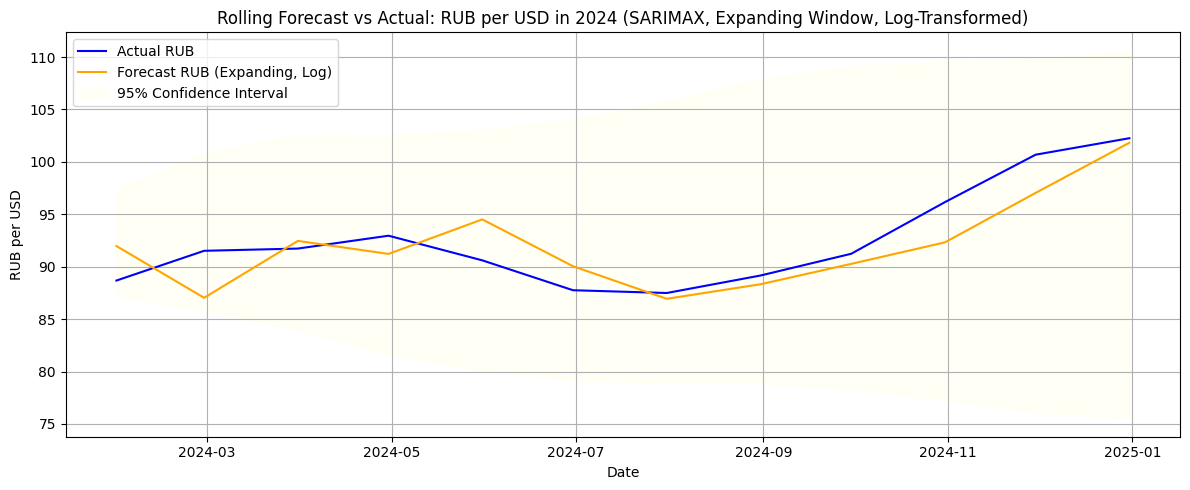

In [37]:
target = 'RUB'
exog_vars = ['Brent_price', 'Brent_price_lag1', 'GDP_per_capita_lag12']
data_model = data_lagged.dropna(subset=[target] + exog_vars).copy()


holdout_start = '2024-01-31'
holdout_end = '2024-12-31'
holdout_dates = data_model.loc[holdout_start:holdout_end].index


initial_window = 60  # Start with 60 months

preds = []
actuals = []

for date in holdout_dates:
    test_idx = data_model.index.get_loc(date)
    train_slice = data_model.iloc[:test_idx]
    if len(train_slice) < initial_window:
        continue

    test_slice = data_model.iloc[test_idx:test_idx + 1]

    y_train = np.log(train_slice[target])
    X_train = train_slice[exog_vars]

    y_test_actual = test_slice[target].values[0]
    X_test = test_slice[exog_vars]

    model = SARIMAX(
        y_train,
        exog=X_train,
        order=(2, 1, 2),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    result = model.fit(disp=False)

    forecast_log = result.get_forecast(steps=1, exog=X_test)
    forecast = np.exp(forecast_log.predicted_mean.iloc[0])
    preds.append(forecast)
    actuals.append(y_test_actual)

# Evaluate
rmse_expanding_log = np.sqrt(mean_squared_error(actuals, preds))
print(f"Rolling Forecast RMSE (Expanding window, log-transformed): {rmse_expanding_log:.2f}")


plt.figure(figsize=(12, 5))
plt.plot(holdout_dates[:len(actuals)], actuals, label='Actual RUB', color='blue')
plt.plot(holdout_dates[:len(preds)], preds, label='Forecast RUB (Expanding, Log)', color='orange')


plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color='lightyellow',
    alpha=0.3,
    label='95% Confidence Interval')


plt.title('Rolling Forecast vs Actual: RUB per USD in 2024 (SARIMAX, Expanding Window, Log-Transformed)')
plt.xlabel('Date')
plt.ylabel('RUB per USD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Rolling Forecast RMSE for 2024: 4.28


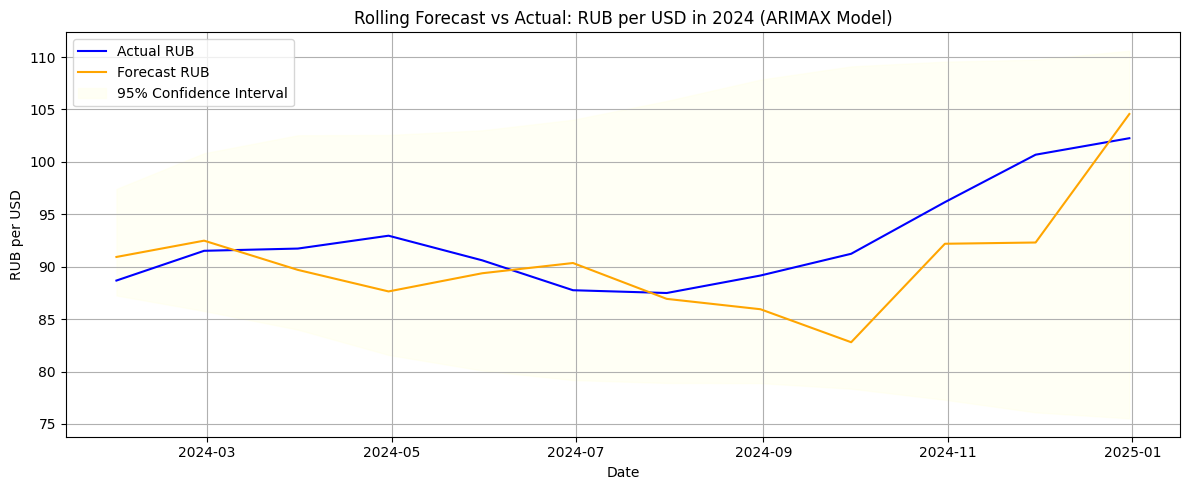

In [ ]:
target = 'RUB'
exog_vars = ['Brent_price', 'Brent_price_lag1', 'GDP_per_capita']
data_model = data_lagged.dropna(subset=[target] + exog_vars).copy()

# Define cutoff and holdout
cutoff_date = '2023-12-31'
holdout_start = '2024-01-31'
holdout_end = '2024-12-31'

window_size = 24  # 2 years of training data

# Filter data
train_val_data = data_model.loc[:cutoff_date]
test_data = data_model.loc[holdout_start:holdout_end]

# Prepare lists
preds, actuals, dates = [], [], []

# Rolling forecast for each month in 2024
for date in test_data.index:
    train_end = date - pd.DateOffset(months=1)
    train_start = train_end - pd.DateOffset(months=window_size - 1)
    
    train_slice = data_model.loc[train_start:train_end]
    test_slice = data_model.loc[[date]]  # keep as DataFrame

    y_train = train_slice[target]
    X_train = train_slice[exog_vars]

    y_test = test_slice[target].values[0]
    X_test = test_slice[exog_vars]

    model = SARIMAX(y_train, exog=X_train, order=(2,1,2),
                    enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit(disp=False)

    forecast = result.get_forecast(steps=1, exog=X_test)
    preds.append(forecast.predicted_mean.iloc[0])
    actuals.append(y_test)
    dates.append(date)

# Convert to Series
forecast_series = pd.Series(preds, index=dates)
actual_series = pd.Series(actuals, index=dates)

# RMSE
rmse_2024 = np.sqrt(mean_squared_error(actual_series, forecast_series))
print(f"Rolling Forecast RMSE for 2024: {rmse_2024:.2f}")

# Plot
plt.figure(figsize=(12, 5))
plt.plot(actual_series.index, actual_series, label='Actual RUB', color='blue')
plt.plot(forecast_series.index, forecast_series, label='Forecast RUB', color='orange')

plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color='lightyellow',
    alpha=0.3,
    label='95% Confidence Interval')

plt.title('Rolling Forecast vs Actual: RUB per USD in 2024 (ARIMAX Model)')
plt.xlabel('Date')
plt.ylabel('RUB per USD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

To conclude the forecasting section, I implemented a SARIMAX model using a log-transformed target variable and an expanding window approach. This method allowed the model to gradually learn from all available past data while maintaining robustness to outliers and volatility shifts through log scaling.

The resulting model achieved the lowest RMSE of 2.66 for 2024 Year, outperforming all previous configurations. This indicates improved predictive accuracy and stability, especially during periods of rapid RUB movement.

This final specification balances flexibility, long-term learning, and variance stabilization — making it a strong candidate for reliable medium-term exchange rate forecasting.

2.4 Log-Transformed RUB Rolling Windows (windows size = 60) for Year 2025

In this section, I apply a log-transformed SARIMAX model with an expanding window approach to forecast RUB/USD throughout 2025. The model is trained on historical data from 1992 to 2024 and updated monthly as new observations become available. Since official macroeconomic data for 2025 has not yet been published, I use estimated values from credible sources.

Rolling Forecast RMSE (Expanding window, log-transformed): 3.81


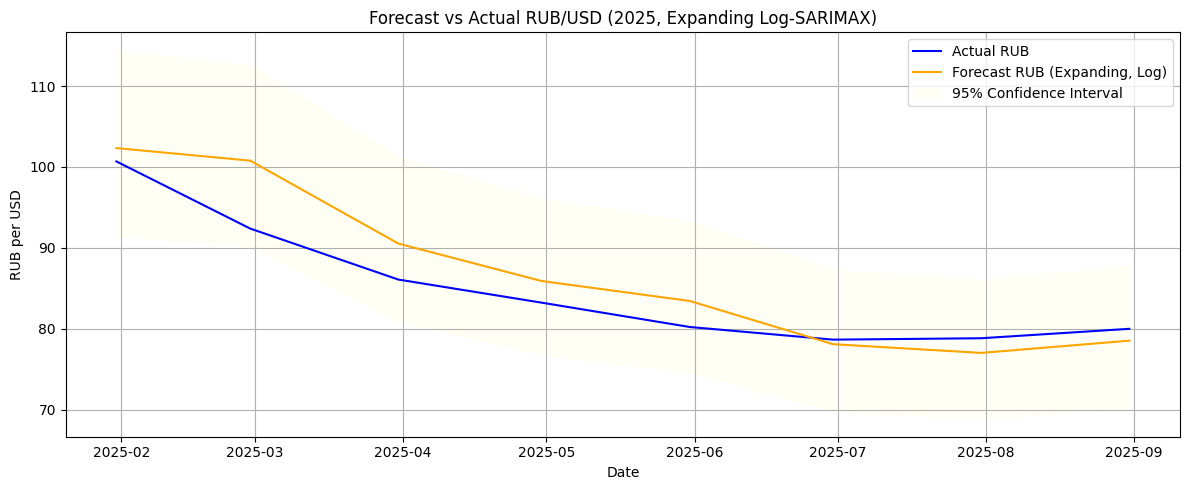

In [36]:
target = 'RUB'
exog_vars = ['Brent_price', 'Brent_price_lag1', 'GDP_per_capita_lag12']
data_model = data_lagged.dropna(subset=[target] + exog_vars).copy()

# Define 2025 holdout
holdout_start = '2025-01-31'
holdout_end = '2025-12-31'
holdout_dates = data_model.loc[holdout_start:holdout_end].index

initial_window = 60  # start with 5 years of training
preds, actuals, forecast_ci_lower, forecast_ci_upper, used_dates = [], [], [], [], []

for date in holdout_dates:
    test_idx = data_model.index.get_loc(date)
    train_slice = data_model.iloc[:test_idx]
    if len(train_slice) < initial_window:
        continue

    test_slice = data_model.iloc[test_idx:test_idx + 1]

    y_train = np.log(train_slice[target])
    X_train = train_slice[exog_vars]

    y_test_actual = test_slice[target].values[0]
    X_test = test_slice[exog_vars]

    model = SARIMAX(y_train, exog=X_train, order=(2, 1, 2),
                    enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit(disp=False)

    forecast_log = result.get_forecast(steps=1, exog=X_test)
    forecast = np.exp(forecast_log.predicted_mean.iloc[0])
    conf_int = np.exp(forecast_log.conf_int())

    preds.append(forecast)
    actuals.append(y_test_actual)
    forecast_ci_lower.append(conf_int.iloc[0, 0])
    forecast_ci_upper.append(conf_int.iloc[0, 1])
    used_dates.append(date)

# Evaluate RMSE
rmse_expanding_log = np.sqrt(mean_squared_error(actuals, preds))
print(f"Rolling Forecast RMSE (Expanding window, log-transformed): {rmse_expanding_log:.2f}")

# Plot
plt.figure(figsize=(12, 5))
plt.plot(used_dates, actuals, label='Actual RUB', color='blue')
plt.plot(used_dates, preds, label='Forecast RUB (Expanding, Log)', color='orange')
plt.fill_between(used_dates, forecast_ci_lower, forecast_ci_upper,
                 color='lightyellow', alpha=0.3, label='95% Confidence Interval')
plt.title(f'Forecast vs Actual RUB/USD (2025, Expanding Log-SARIMAX)')
plt.xlabel('Date')
plt.ylabel('RUB per USD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The forecast captures the overall downward trend in RUB/USD fairly well, although it slightly overestimates the exchange rate during certain months. With an RMSE of 3.81, the model demonstrates solid predictive performance given the uncertainty of future inputs.

### Summary:

This notebook explores ...

Next steps:

* 